# Plant Disease Using Siamese Network - Keras

We will understand the siamese network by building the plant disease model. The objective of our network is to understand whether two plants are similar or dissimilar.
 Once we have our data as pairs along with their labels, we train our siamese network. From the image pair, we feed one image to the network A and another image to the network B. The role of these two networks is only to extract the feature vectors. So, we use two convolution layers with relu activations for extracting the features. Once we have learned the feature, we feed the resultant feature vector from both of the networks to the energy function which measures the similarity, we use Euclidean distance as our energy function. So, we train our network by feeding the image pair to learn the semantic similarity between them.

References :
 * https://github.com/sudharsan13296/Hands-On-Meta-Learning-With-Python/blob/master/02.%20Face%20and%20Audio%20Recognition%20using%20Siamese%20Networks/2.4%20Face%20Recognition%20Using%20Siamese%20Network.ipynb
 * https://keras.io/examples/mnist_siamese/
 * https://msiam.github.io/Few-Shot-Learning/
 * https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
 * https://medium.com/@subham.tiwari186/siamese-neural-network-for-one-shot-image-recognition-paper-analysis-44cf7f0c66cb
 * https://www.katnoria.com/siamese-one-shot/
 * https://sorenbouma.github.io/blog/oneshot/

In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import optimizers

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
import json
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
selected_image_size = 224
resize = True
total_sample_size = 5000 # 5k-50k ... Depends on your ram

channel = 1
size = 2

folder_count = 38
image_count = 20 #0-50

if resize == True:
    batch_size=256
else:
    batch_size=64

path =  os.path.join('../input/plantvillage/plantvillage_resize_224/PlantVillage_resize_224/')
print(path)

../input/plantvillage/plantvillage_resize_224/PlantVillage_resize_224/


Now, we define a function for reading our input image. The function read_image takes input as an image and returns the numpy array.
 These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function. Next, we define our loss function as contrastive_loss function and compile the model.

In [3]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

For an example, Let us open one image,

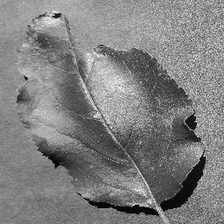

In [4]:
Image.open(path+'s1/1.jpg')

In [5]:
image = mpimg.imread(path+'s1/1.jpg')
dim1 = image.shape[0]
print('dim1',dim1)
dim2 = image.shape[1]
print('dim2',dim2)

dim1 224
dim2 224


In [6]:
image.shape

(224, 224)

Now, we define another function get_data for generating our data. As we know, for the Siamese network, data should be in the form of pairs (genuine and imposite) with a binary label.
 
 First, we read the images (img1, img2) from the same directory and store them in the x_genuine_pair array and assign y_genuine to 1. Next, we read the images (img1, img2) from the different directory and store them in the x_imposite pair and assign y_imposite to 0.
 
 Finally, we concatenate both x_genuine_pair, x_imposite to X and y_genuine, y_imposite to Y:

In [7]:
def get_data(size, total_sample_size):
    #read the image
    image = mpimg.imread(path+'s' + str(1) + '/' + str(1) + '.jpg', 'rw+')
    #reduce the size
    if resize == True:
        image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0

    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])

    y_genuine = np.zeros([total_sample_size,1])

    for i in range(folder_count):
        for j in range(int(total_sample_size/folder_count)):
            ind1 = 0
            ind2 = 0

            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(image_count)
                ind2 = np.random.randint(image_count)

            # read the two images
            img1 = mpimg.imread(path+'s' + str(i+1) + '/' + str(ind1 + 1) + '.jpg', 'rw+')
            img2 = mpimg.imread(path+'s' + str(i+1) + '/' + str(ind2 + 1) + '.jpg', 'rw+')

            #reduce the size
            if resize == True:
                img1 = img1[::size, ::size]
                img2 = img2[::size, ::size]

            #store the images to the initialized numpy array
            print
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2

            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])

    for i in range(int(total_sample_size/image_count)):
        for j in range(image_count):

            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(folder_count)
                ind2 = np.random.randint(folder_count)
                if ind1 != ind2:
                    break

            img1 = mpimg.imread(path+'s' + str(ind1+1) + '/' + str(j + 1) + '.jpg', 'rw+')
            img2 = mpimg.imread(path+'s' + str(ind2+1) + '/' + str(j + 1) + '.jpg', 'rw+')

            if resize == True:
                img1 = img1[::size, ::size]
                img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1

    #now, concatenate, genuine pairs and imposite pair to get the whole data
    #print(x_geuine_pair.shape)
    #print(x_imposite_pair.shape)
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y
X, Y = get_data(size, total_sample_size)


 Now, we generate our data and check our data size. As you can see we have 20,000 data points, out of these 10,000 are genuine pairs and 10,000 are imposite pairs.

In [8]:
X.shape

(10000, 2, 1, 112, 112)

In [9]:
Y.shape

(10000, 1)

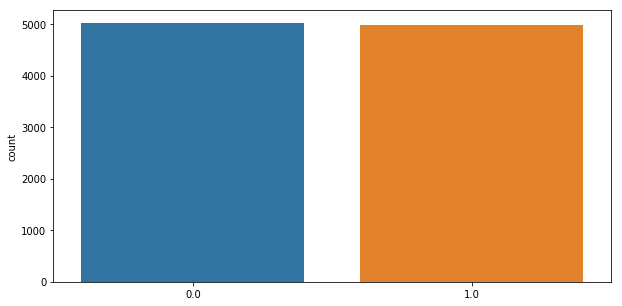

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.countplot(Y[:,0])
plt.show()

Next, we split our data for training and testing with 85% training and 15% testing proportions:

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.15)

In [12]:
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (8500, 2, 1, 112, 112)
x_test (1500, 2, 1, 112, 112)
y_train (8500, 1)
y_test (1500, 1)


Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

In [13]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [16, 32, 16]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[2], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

Next, we feed the image pair, to the base network, which will return the embeddings that is, feature vectors:

In [14]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
print('input_dim',input_dim)

input_dim (1, 112, 112)


In [15]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [16]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

Now, we set the epoch length to 20 and we use RMS prop for optimization and define our model.

In [17]:
epochs = 20
rms = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#RMSprop()
rms = RMSprop()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [18]:
model = Model(input=[img_a, img_b], output=distance)
model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 112, 112)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 112, 112)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           652674      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

In [19]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]
img_1.shape
history = model.fit([img_1, img2], y_train, validation_split=.20,
      batch_size= batch_size, verbose=1, nb_epoch=epochs, callbacks=callback_early_stop_reduceLROnPlateau)

# Option 1: Save Weights + Architecture
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
print('saved')

Train on 6800 samples, validate on 1700 samples
Epoch 1/20
6800/6800 [==============================] - 8s 1ms/step - loss: 0.2891 - accuracy: 0.5203 - val_loss: 0.5012 - val_accuracy: 0.4753
Epoch 2/20
6800/6800 [==============================] - 3s 487us/step - loss: 0.2592 - accuracy: 0.5501 - val_loss: 0.4550 - val_accuracy: 0.4753
Epoch 3/20
6800/6800 [==============================] - 3s 490us/step - loss: 0.2491 - accuracy: 0.5822 - val_loss: 0.3725 - val_accuracy: 0.4753
Epoch 4/20
6800/6800 [==============================] - 3s 483us/step - loss: 0.2428 - accuracy: 0.5875 - val_loss: 0.4037 - val_accuracy: 0.4753
Epoch 5/20
6800/6800 [==============================] - 3s 487us/step - loss: 0.2357 - accuracy: 0.6076 - val_loss: 0.3771 - val_accuracy: 0.4753
Epoch 6/20
6800/6800 [==============================] - 3s 489us/step - loss: 0.2227 - accuracy: 0.6397 - val_loss: 0.3335 - val_accuracy: 0.4800
Epoch 7/20
6800/6800 [==============================] - 3s 486us/step - loss: 

Now, we make predictions with test data. Finally, we check our model accuracy.

In [20]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

print('Accuracy on test set: %0.2f%%' % (100 * compute_accuracy(pred, y_test)))

Accuracy on test set: 73.35%


In [21]:
pred = model.predict([x_train[:, 0], x_train[:, 1]])

print('* Accuracy on training set: %0.2f%%' % (100  * compute_accuracy(pred, y_train)))

* Accuracy on training set: 76.02%


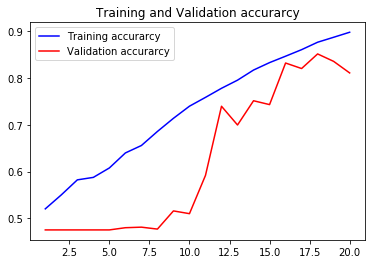

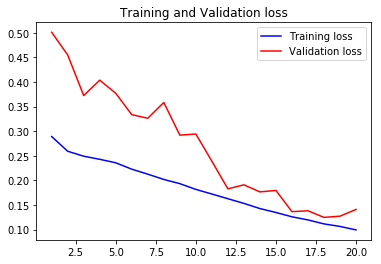

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Test

In [23]:
if resize==True:
    selected_image_size = int(selected_image_size/2)
    print('selected_image_size',selected_image_size)

selected_image_size 112


In [24]:
target_label = 1
values = np.array(y_test[:,0])

target_index = values.tolist().index(target_label)
print(target_index)
print('target_index value : ',y_test[target_index])

2
target_index value :  [1.]


(112, 112)


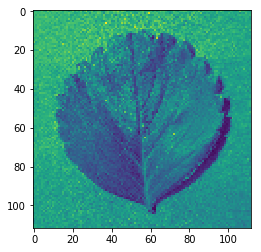

In [25]:
img1 = (x_test[target_index, 0] * 255).astype(np.uint8)
img1 = img1.reshape(selected_image_size,selected_image_size)
print(img1.shape)
img1
plt.imshow(img1)
plt.show()

(112, 112)


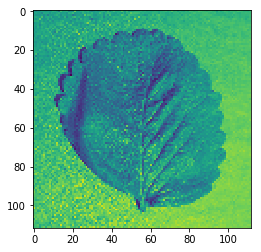

In [26]:
img2 = (x_test[target_index, 1] * 255).astype(np.uint8)
img2 = img2.reshape(selected_image_size,selected_image_size)
print(img2.shape)
img2
plt.imshow(img2)
plt.show()

In [27]:
x_test[target_index:target_index+1, 0].shape

(1, 1, 112, 112)

In [28]:
pred = model.predict([x_test[target_index:target_index+1, 0], x_test[target_index:target_index+1, 1]])
pred = pred < 0.5
print('y_test[target_index]:',y_test[target_index,0]==True,' pred :',pred)

y_test[target_index]: True  pred : [[ True]]
